## Fine-tuning with chainer

In this example, we're going to fit the trained model to another dataset called 'fine tuning' or 'transfer learning'.  
Download the 'CaffeNet' model file and set the correct paths to these files.  
* caffemodel: https://github.com/BVLC/caffe/tree/master/models/bvlc_reference_caffenet  
* meanfile: https://github.com/BVLC/caffe/tree/master/python/caffe/imagenet 

In [1]:
path_to_model = 'caffenet/bvlc_reference_caffenet.caffemodel'
path_to_mean = 'caffenet/ilsvrc_2012_mean.npy'

We'll also use the OxFord Flowers 17 dataset.  
Download the dataset from the following URL, extract 'jpg' directory and set the correct path.   
* http://www.robots.ox.ac.uk/~vgg/data/bicos/

In [2]:
path_to_dataset = 'oxfordflower17/'

CaffeNet uses the mean subtracted images so that the prediction accuracy of the network improves. We should subtract the pre-computed mean value from every color channel before training.

In [3]:
import numpy as np
mean = np.load(path_to_mean).mean(1).mean(1)
print mean # BGR order

[ 104.00698793  116.66876762  122.67891434]


Take care that CaffeNet uses images which shape is 3x227x227, the each value ranges from 0 to 255, the mean subtracted and BGR order not RGB.

In [4]:
import skimage as ski
from skimage import io, transform
    
def improcess(path_to_im):
    im = ski.io.imread(path_to_im)
    im = ski.transform.resize(im, (227, 227))
    im = im.transpose(2, 0, 1) # in order (color, height, width)
    im *= 255
    im = im[[2, 1, 0], :, :] # RGB to BGR order
    im -= mean[:, np.newaxis, np.newaxis]
    return im.astype(np.float32)

def imdeprocess(data):
    im = data + mean[:, np.newaxis, np.newaxis]
    im = im[[2, 1, 0], :, :]
    im /= 255
    im = im.transpose(1, 2, 0)
    return im

Load the dataset and pre-process the images.  
The OxFord Flowers 17 dataset includes 80 images per category. Now we devided it in half (for training and test).

In [5]:
np.random.seed(777)
filenames = np.loadtxt(path_to_dataset + 'jpg/files.txt', dtype=str)
train_data = []
train_labels = []
test_data = []
test_labels = []

for i,filename in enumerate(filenames):
    im = improcess(path_to_dataset + 'jpg/' + filename)
    if i % 80 == 0: 
        perm = np.random.permutation(80)
    if perm[i % 80] < 40:
        train_data.append(im)
        train_labels.append(i // 80)
    else:
        test_data.append(im)
        test_labels.append(i // 80)

In [6]:
# shuffle the data for training
perm = np.random.permutation(len(train_data))
train_labels = np.array(train_labels).astype(np.int32)[perm]
train_data = np.array(train_data)[perm]

# shuffle the data for test
perm = np.random.permutation(len(test_data))
test_labels = np.array(test_labels).astype(np.int32)[perm]
test_data = np.array(test_data)[perm]

In [7]:
label_names = ['Daffodil', 'Snowdrop', 'Lily Valley', 'Bluebell',
               'Crocus', 'Iris', 'Tigerlily', 'Tulip', 'Fritillary',
               'Sunflower', 'Daisy', 'Colls\' Foot', 'Dandelion',
               'Cowslip', 'Buttercup', 'Windflower', 'Pansy']

Let's take a look at some data in the dataset.

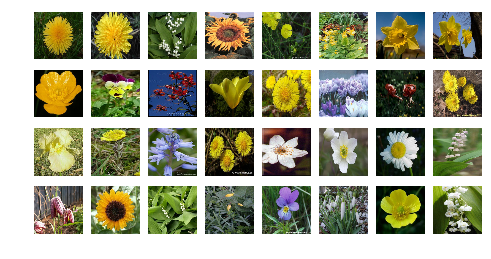

In [8]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
plt.figure(figsize=(8, 4))
for i in range(32):
    plt.subplot(4, 8, i+1)
    plt.axis('off')
    plt.imshow(imdeprocess(train_data[i]))

Import chainer and the dependencies.

In [9]:
import six
import chainer
from chainer import cuda
import chainer.functions as F
import chainer.links as L
from chainer import optimizers
from chainer import serializers

Import the CaffeNet model to chainer (may take a few minutes).  
Then save the model in the chainer format.

In [10]:
import chainer.functions.caffe
caffenet = chainer.functions.caffe.CaffeFunction(path_to_model)
chainer.serializers.save_hdf5('caffenet/caffenet.chainermodel', caffenet)

Finally, let's start fine-tuing.  
For further training of CaffeNet layers, redefine the model and load weights from caffemodel.  
We need to describe the name and parameters of the layers correctly as the network difinition file of CaffeNet.  
* https://github.com/BVLC/caffe/blob/master/models/bvlc_reference_caffenet/deploy.prototxt

Then define the architecture of the network in "`def forward`".  
We modified LRN (local response normalization) layers, because LRN in caffe implementation is different from one in chainer.

In [11]:
! cat caffenet.py

import chainer
import chainer.functions as F
import chainer.links as L
import numpy as np

class CaffeNet(chainer.Chain):

    def __init__(self):
        self.caffe = chainer.Chain(
            conv1 = L.Convolution2D(3, 96, ksize=11, stride=4),
            conv2 = L.Convolution2D(96, 256, ksize=5, pad=2),
            conv3 = L.Convolution2D(256, 384, ksize=3, pad=1),
            conv4 = L.Convolution2D(384, 384, ksize=3, pad=1),
            conv5 = L.Convolution2D(384, 256, ksize=3, pad=1),
            fc6 = L.Linear(9216, 4096),
            fc7 = L.Linear(4096, 4096),
        )
        self.fine = chainer.Chain(
            fc8ft = F.Linear(4096, 17),
        )

    def __call__(self, x, t, train=True):
        y = self.forward(x, train=train)
        self.loss = F.softmax_cross_entropy(y, t)
        self.accuracy = F.accuracy(y, t)
        return self.loss

    def forward(self, x, train=False):
        self.data = x
        self.conv1 = F.relu(self.caffe.conv1(self.data))
        

In [12]:
from caffenet import CaffeNet
model = CaffeNet()
chainer.serializers.load_hdf5('caffenet/caffenet.chainermodel', model.caffe)

Set the optimizer. We should drop the learning rate in trained layers because they need less tuning than initialized layers. The learning rate of the CaffeNet have been already dropped by $10^{-4}$ after 450,000 iterations. We can train only the last layer is another way if you want to get the training converged faster.

In [13]:
opt_caffe = chainer.optimizers.Adam(alpha=1e-6) # default:1e-3
opt_caffe.setup(model.caffe)
opt_fine = chainer.optimizers.Adam()
opt_fine.setup(model.fine)

If you use a gpu, set the gpu device value here.

In [14]:
gpuid = 0 # gpu device ID (cpu if negative)
xp = cuda.cupy if gpuid >= 0 else np

if gpuid >= 0:
    cuda.get_device(gpuid).use()
    model.caffe.to_gpu()
    model.fine.to_gpu()

Define a function to evalute the net.

In [15]:
import csv

log_train = open('ft_train.log', 'w')
writer_train = csv.writer(log_train, lineterminator='\n')
writer_train.writerow(('iter', 'loss'))

log_test = open('ft_test.log', 'w')
writer_test = csv.writer(log_test, lineterminator='\n')
writer_test.writerow(('iter', 'loss', 'acc'))

In [16]:
import sys
from tqdm import tqdm
batchsize = 20

def test(x, t):
    sum_accuracy = sum_loss = 0
    with tqdm(total=len(t)) as pbar:
        pbar.set_description('test')
        for i in range(0, len(t), batchsize):
            pbar.update(batchsize)
            x_batch = chainer.Variable(xp.asarray(x[i:i + batchsize]), volatile='on')
            t_batch = chainer.Variable(xp.asarray(t[i:i + batchsize]), volatile='on')
            loss = model(x_batch, t_batch, train=False)
            sum_loss += float(loss.data)
            sum_accuracy += float(model.accuracy.data)
    sys.stderr.flush()
    return sum_loss * batchsize / len(t), sum_accuracy * batchsize / len(t)

In [17]:
loss, acc = test(test_data, test_labels)
writer_test.writerow((0, loss, acc))
sys.stdout.write('test: loss={0:.6f}, accuracy={1:.6f}'.format(loss, acc))

test: 100%|██████████| 680/680 [00:00<00:00, 724.27it/s]


test: loss=3.848890, accuracy=0.036765

Train the model by forward and backward computations.

In [18]:
n_epoch = 10
n_data = len(train_labels)

# Learning loop
for epoch in range(n_epoch):
    sys.stdout.write('(epoch: {})\n'.format(epoch + 1))
    sys.stdout.flush()
    
    # training
    perm = np.random.permutation(n_data)
    with tqdm(total=n_data) as pbar:
        for i in range(0, n_data, batchsize):
            it = epoch * n_data + i + batchsize
            x = chainer.Variable(xp.asarray(train_data[perm[i:i + batchsize]]), volatile='off')
            t = chainer.Variable(xp.asarray(train_labels[perm[i:i + batchsize]]), volatile='off')
            opt_fine.zero_grads(); opt_caffe.zero_grads()
            loss = model(x, t); loss.backward()
            opt_fine.update(); opt_caffe.update()
            loss = float(model.loss.data)
            writer_train.writerow((it, loss))
            pbar.set_description('train: loss={0:.6f}'.format(loss))
            pbar.update(batchsize)
    sys.stderr.flush()
    
    # evaluate
    loss, acc = test(test_data, test_labels)
    writer_test.writerow((it, loss, acc))
    sys.stdout.write('test: loss={0:.6f}, accuracy={1:.6f}\n'.format(loss, acc))

(epoch: 1)


test: 100%|██████████| 680/680 [00:00<00:00, 1300.13it/s]


test: loss=0.578332, accuracy=0.811765
(epoch: 2)


test: 100%|██████████| 680/680 [00:00<00:00, 1293.51it/s]


test: loss=0.384779, accuracy=0.872059
(epoch: 3)


test: 100%|██████████| 680/680 [00:00<00:00, 1294.30it/s]


test: loss=0.364327, accuracy=0.880882
(epoch: 4)


test: 100%|██████████| 680/680 [00:00<00:00, 1297.52it/s]


test: loss=0.344661, accuracy=0.886765
(epoch: 5)


test: 100%|██████████| 680/680 [00:00<00:00, 1292.71it/s]


test: loss=0.329236, accuracy=0.895588
(epoch: 6)


test: 100%|██████████| 680/680 [00:00<00:00, 1291.89it/s]


test: loss=0.327905, accuracy=0.892647
(epoch: 7)


test: 100%|██████████| 680/680 [00:00<00:00, 1287.28it/s]


test: loss=0.321051, accuracy=0.892647
(epoch: 8)


test: 100%|██████████| 680/680 [00:00<00:00, 1284.94it/s]


test: loss=0.339407, accuracy=0.905882
(epoch: 9)


test: 100%|██████████| 680/680 [00:00<00:00, 1292.72it/s]


test: loss=0.327145, accuracy=0.892647
(epoch: 10)


test: 100%|██████████| 680/680 [00:00<00:00, 1292.59it/s]


test: loss=0.325042, accuracy=0.892647


Plot the losses and the accuracies.

In [19]:
log_train.close()
log_test.close()
log_train = np.loadtxt('ft_train.log', delimiter=',', skiprows=True).transpose()
log_test = np.loadtxt('ft_test.log', delimiter=',', skiprows=True).transpose()

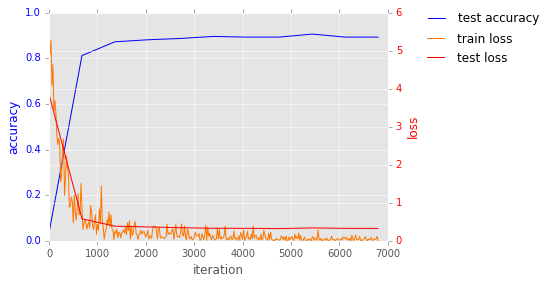

In [20]:
fig, ax1 = plt.subplots()
ax1.plot(log_test[0], log_test[2], 'b-')
ax1.set_xlabel('iteration')
ax1.set_ylabel('accuracy', color='b')
ax1.set_ylim(0, 1)
for tl in ax1.get_yticklabels():
    tl.set_color('b')
plt.legend(['test accuracy'], bbox_to_anchor=(1.48, 1.05), framealpha=0)
ax2 = ax1.twinx()
ax2.plot(log_train[0], log_train[1], color='#ff7700')
ax2.plot(log_test[0], log_test[1], 'r-')
ax2.set_ylabel('loss', color='r')
for tl in ax2.get_yticklabels():
    tl.set_color('r')
plt.legend(['train loss', 'test loss'], bbox_to_anchor=(1.4, 0.96), framealpha=0)
plt.tight_layout()
plt.show()

Now we achieved 90% accuracy in the validation data after 10 epochs. Let's classify one of the data.

In [21]:
def predict(x, top=5):
    x = x.reshape(1, 3, 227, 227)
    x_batch = chainer.Variable(xp.asarray(x),  volatile='on')
    y_batch = F.softmax(model.forward(x_batch))
    results = list(zip(y_batch.data[0], label_names))
    results.sort(reverse=True)
    for rank, (score, name) in enumerate(results[:top], start=1):
        print('#{0:2d}| {1:12s} | {2:7.3f}%'.format(rank, name, float(score*100)))

# 1| Buttercup    |  90.449%
# 2| Iris         |   7.200%
# 3| Daffodil     |   1.860%
# 4| Sunflower    |   0.279%
# 5| Tigerlily    |   0.156%


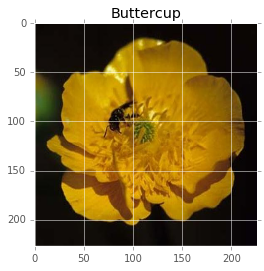

In [22]:
plt.imshow(imdeprocess(test_data[0]), interpolation='none')
plt.title(label_names[test_labels[0]])
predict(test_data[0])